# Emission Distribution Selection

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml


from recurrent_health_events_prediction.model.model_types import DistributionType

from recurrent_health_events_prediction.model_selection.gmm_utils import (
    calculate_log_likelihood,
    get_number_params_of_distribution,
    get_gmm_params_df,
    calculate_aic,
    calculate_bic,
    plot_model_gmm_selection_results,
    gmm_model_selection
)

## Synthetic Test

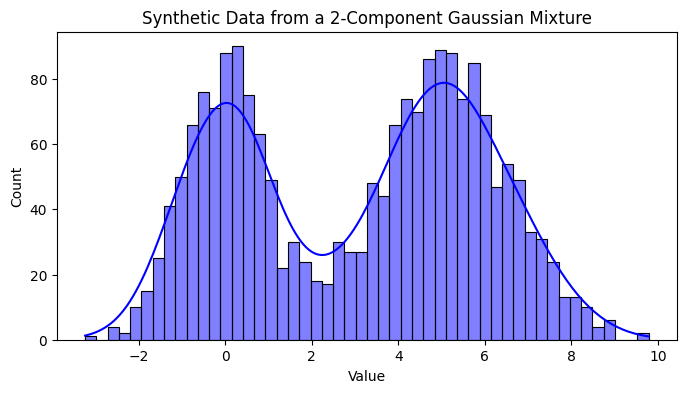

In [2]:
np.random.seed(42)

n_samples = 2000

# Define means and stds for the two components
means = [0, 5]
stds = [1, 1.5]
weights = [0.4, 0.6]

# Number of points from each component
n1 = int(weights[0] * n_samples)
n2 = n_samples - n1

# Generate samples
samples1 = np.random.normal(loc=means[0], scale=stds[0], size=n1)
samples2 = np.random.normal(loc=means[1], scale=stds[1], size=n2)

# Combine
synthetic_data = np.hstack([samples1, samples2])
np.random.shuffle(synthetic_data)

# Visualize
plt.figure(figsize=(8, 4))
sns.histplot(synthetic_data, bins=50, kde=True, color="blue")
plt.title("Synthetic Data from a 2-Component Gaussian Mixture")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


GMM-2 components: BIC=9079.87, AIC=9057.46
GMM-3 components: BIC=9095.22, AIC=9061.61
GMM-4 components: BIC=9110.38, AIC=9065.58
GMM-5 components: BIC=9123.23, AIC=9067.22



Best GMM: 1 components (BIC=9079.87)


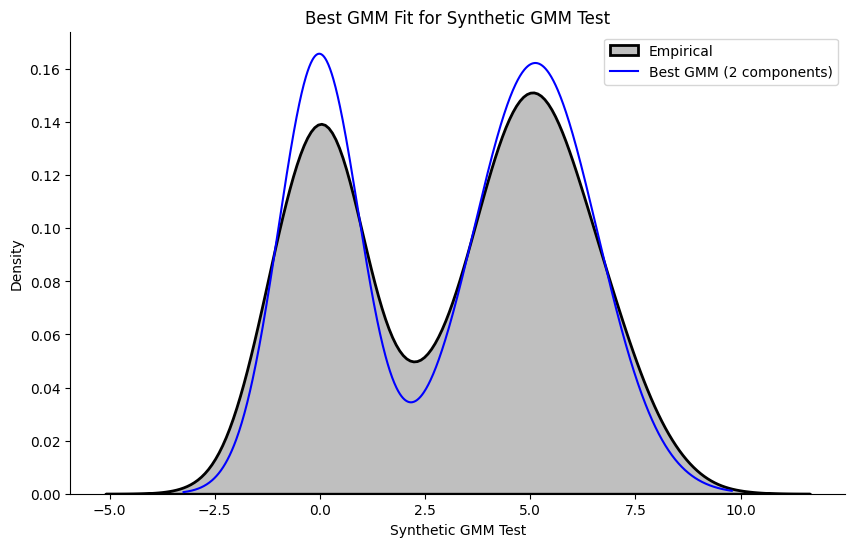

In [3]:
best_gmm = gmm_model_selection(
    data=synthetic_data,
    max_components=5,
    var_name="Synthetic GMM Test",
    distribution_type=DistributionType.GAUSSIAN,  # or whatever matches your Enum
)


## Import MIMIC Dataset

In [3]:
with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_path"]
historical_events_df = pd.read_csv(training_data_path + "/multiple_hosp_patients/historical_events.csv")

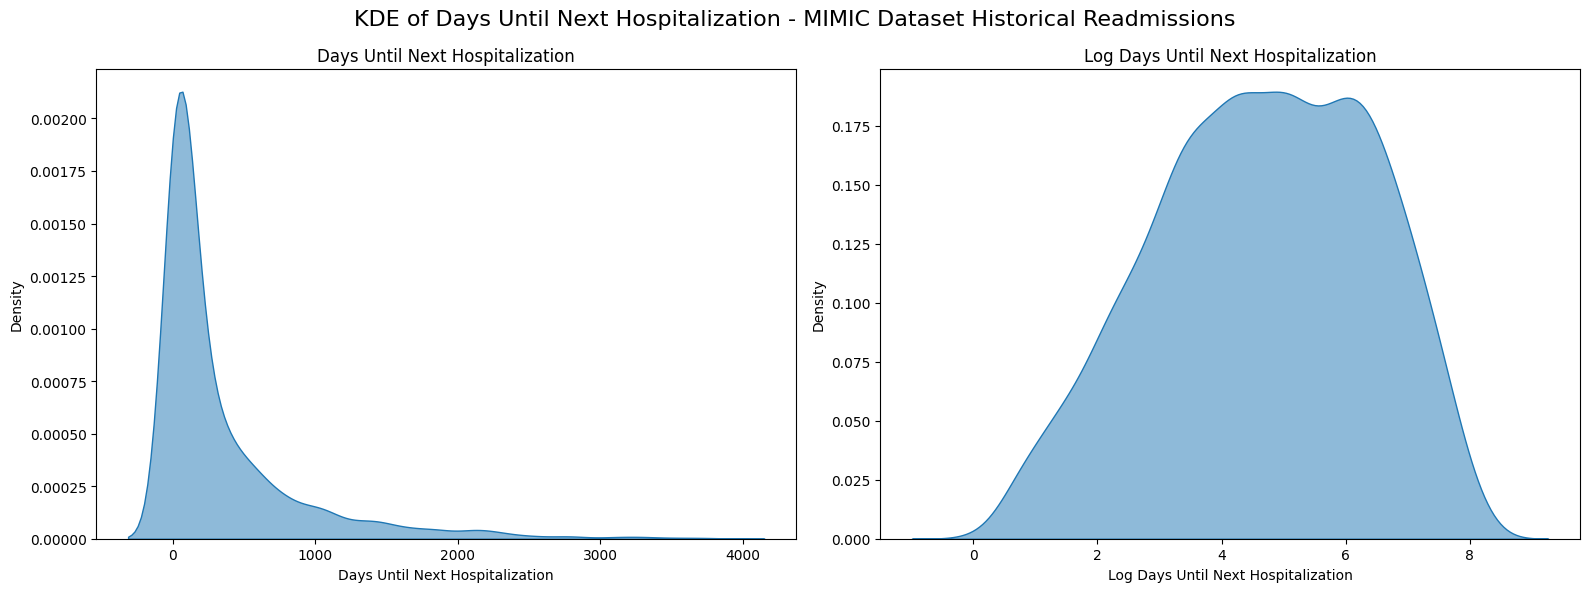

In [5]:
historical_events_time_until_next_hosp_df = historical_events_df[historical_events_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot KDE for DAYS_UNTIL_NEXT_HOSPITALIZATION
sns.kdeplot(data=historical_events_time_until_next_hosp_df, alpha=0.5, fill=True, x='DAYS_UNTIL_NEXT_HOSPITALIZATION', ax=axes[0])
axes[0].set_title('Days Until Next Hospitalization')
axes[0].set_xlabel('Days Until Next Hospitalization')
axes[0].set_ylabel('Density')

# Plot KDE for LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
sns.kdeplot(data=historical_events_time_until_next_hosp_df, alpha=0.5, fill=True, x='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', ax=axes[1])
axes[1].set_title('Log Days Until Next Hospitalization')
axes[1].set_xlabel('Log Days Until Next Hospitalization')
axes[1].set_ylabel('Density')

# Add a single suptitle
fig.suptitle('KDE of Days Until Next Hospitalization - MIMIC Dataset Historical Readmissions', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
historical_events_time_until_next_hosp_df[["DAYS_UNTIL_NEXT_HOSPITALIZATION", "LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"]].describe()

,DAYS_UNTIL_NEXT_HOSPITALIZATION,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
count,3777.000000,3777.000000
mean,348.886550,4.660787
std,542.299566,1.751075
min,0.019444,0.019258
25%,28.761806,3.393226
50%,113.806944,4.743252
75%,428.922222,6.063604
max,3837.107639,8.252735


In [7]:
data = historical_events_time_until_next_hosp_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].copy()
log_data = np.log1p(data)  # Log transform, ignoring non-positive values
print("Data length:", len(data))
print("Maximum value:", data.max())
print("Minimum value:", data.min())

Data length: 3777
Maximum value: 3837.1076388888887
Minimum value: 0.0194444444444444


In [8]:
data_filtered = data[data < 120]  # Filter out non-positive values for distributions that require positive data
log_data_filtered = np.log1p(data_filtered)  # Log transform
print(f"Data length: {len(data_filtered)}")
print(f"Maximum value: {data_filtered.max()}")
print(f"Minimum value: {data_filtered.min()}")

Data length: 1915
Maximum value: 119.94375
Minimum value: 0.0194444444444444


In [9]:
data_filtered.max()

np.float64(119.94375)

### Single Component

--- Fit Comparison for Days Until Next Hospitalization ---


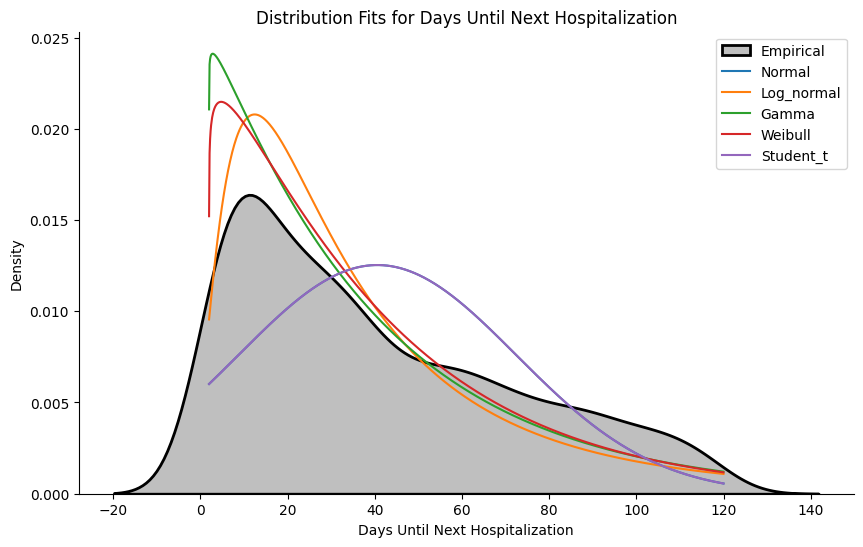

,aic,bic,loglik,ks_stat,ks_pvalue
weibull,15063.035647,15079.204339,-7528.517824,0.054051,0.00015
gamma,15070.99019,15087.158882,-7532.495095,0.055277,0.000097
log_normal,15305.770485,15321.939177,-7649.885243,0.068517,0.0
normal,15803.649501,15814.428629,-7899.82475,0.113553,0.0
student_t,15805.649504,15821.818196,-7899.824752,0.113554,0.0


In [8]:
from recurrent_health_events_prediction.eda.utils import compare_distributions

compare_distributions(data_filtered, 
                      [DistributionType.NORMAL, DistributionType.LOG_NORMAL, 
                       DistributionType.GAMMA, DistributionType.WEIBULL, DistributionType.STUDENT_T],
                      var_name="Days Until Next Hospitalization")

--- Fit Comparison for Log Days Until Next Hospitalization ---


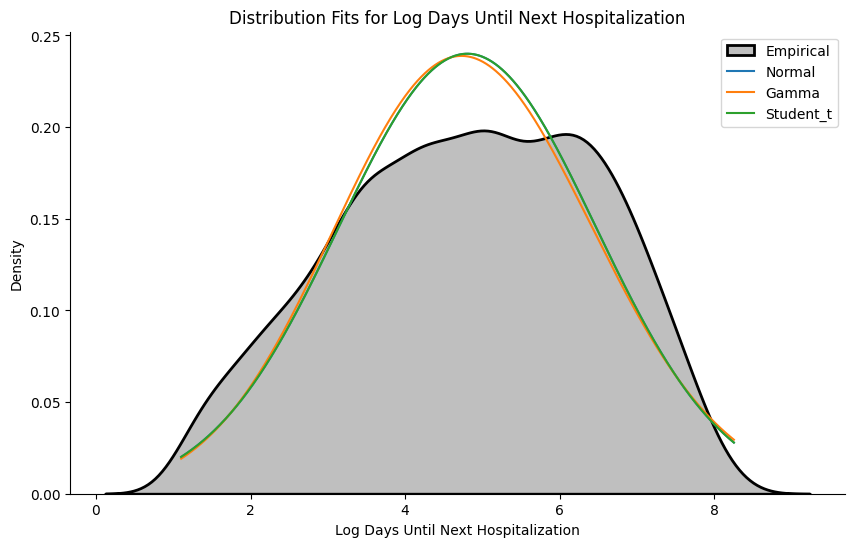

,aic,bic,loglik,ks_stat,ks_pvalue
normal,13015.054951,13027.303845,-6505.527476,0.047871,0.0
student_t,13017.054952,13035.428293,-6505.527476,0.047872,0.0
gamma,13036.517473,13054.890813,-6515.258736,0.050005,0.0


In [9]:
compare_distributions(log_data,
                      [DistributionType.NORMAL,
                       DistributionType.GAMMA, DistributionType.STUDENT_T],
                      var_name="Log Days Until Next Hospitalization")

### Mixture of Components

GMM-2 components: BIC=15034.22, AIC=15012.67
GMM-3 components: BIC=14993.48, AIC=14961.15
GMM-4 components: BIC=14968.33, AIC=14925.21
GMM-5 components: BIC=14968.39, AIC=14914.49
GMM-6 components: BIC=14986.08, AIC=14921.40
GMM-7 components: BIC=14988.98, AIC=14913.52
GMM-8 components: BIC=14990.22, AIC=14903.99
GMM-9 components: BIC=14997.93, AIC=14900.91
GMM-10 components: BIC=15012.84, AIC=14905.05



Best GMM: 3 components (BIC=14968.33)


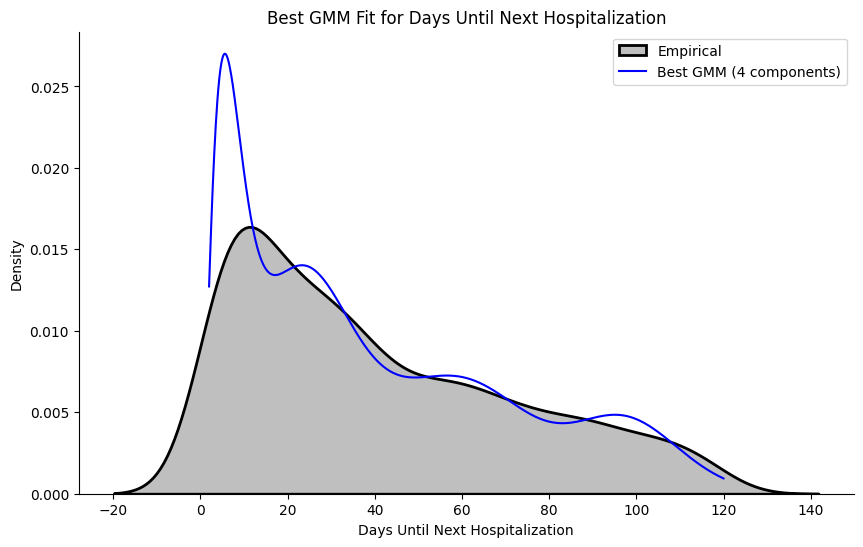

,Component,Distribution,Shape,Rate,Expected Value
0,0,Gamma,2.988029,0.359971,8.300747
1,1,Gamma,17.546537,0.268842,65.267082
2,2,Gamma,73.206871,0.733541,99.799272
3,3,Gamma,6.403235,0.216280,29.606193


In [11]:
best_gmm_model = gmm_model_selection(
    data=data_filtered.values,
    max_components=10,
    var_name="Days Until Next Hospitalization",
    distribution_type=DistributionType.GAMMA  # or whatever matches your Enum
)

get_gmm_params_df(best_gmm_model, DistributionType.GAMMA)

GMM-2 components: BIC=12818.27, AIC=12793.77
GMM-3 components: BIC=12782.81, AIC=12746.06
GMM-4 components: BIC=12786.56, AIC=12737.57
GMM-5 components: BIC=12789.96, AIC=12728.71



Best GMM: 2 components (BIC=12782.81)


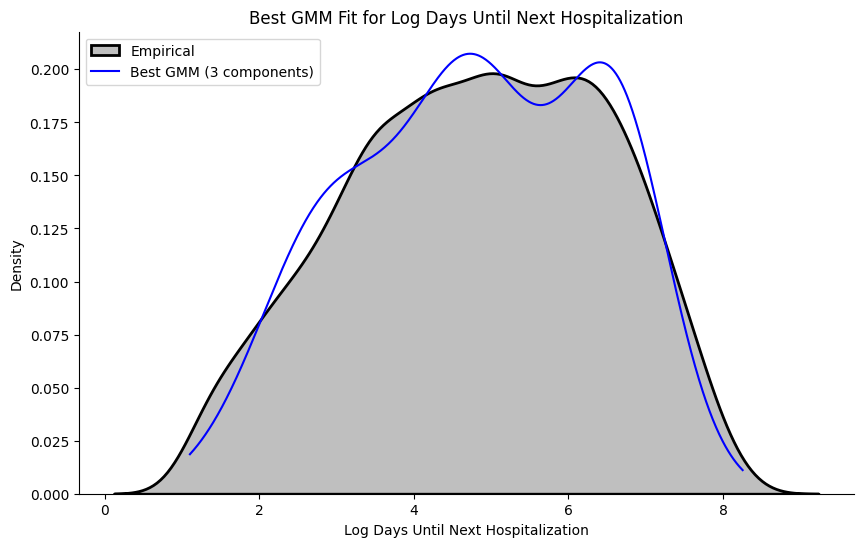

,Component,Distribution,Mean,Variance
0,0,Normal,2.951276,0.864868
1,1,Normal,4.805335,0.634241
2,2,Normal,6.575977,0.500332


In [12]:
best_gmm_model = gmm_model_selection(
    data=log_data.values,
    max_components=5,
    var_name="Log Days Until Next Hospitalization",
    distribution_type=DistributionType.GAUSSIAN  # or whatever matches your Enum
)

get_gmm_params_df(best_gmm_model, DistributionType.NORMAL)

GMM-2 components: BIC=13072.24, AIC=13047.74
GMM-3 components: BIC=12956.22, AIC=12919.47
GMM-4 components: BIC=12902.35, AIC=12853.36
GMM-5 components: BIC=12880.34, AIC=12819.09



Best GMM: 4 components (BIC=12880.34)


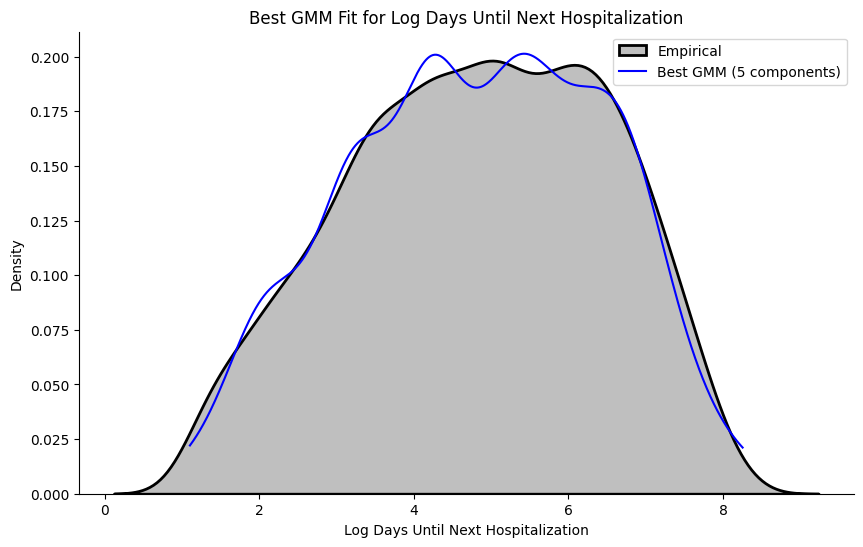

,Component,Distribution,nu (dof),Mean,Variance
0,0,StudentT,5,2.060513,0.343245
1,1,StudentT,5,3.226066,0.301315
2,2,StudentT,5,6.632152,0.543110
3,3,StudentT,5,4.227224,0.266710
4,4,StudentT,5,5.350919,0.424683


In [13]:
best_gmm_model = gmm_model_selection(
    data=log_data.values,
    max_components=5,
    var_name="Log Days Until Next Hospitalization",
    distribution_type=DistributionType.STUDENT_T  # or whatever matches your Enum
)

get_gmm_params_df(best_gmm_model, DistributionType.STUDENT_T)